In [2]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from darts import TimeSeries

from statsmodels.graphics.tsaplots import plot_pacf
from darts.utils.statistics import plot_acf, check_seasonality
from darts.models import ExponentialSmoothing, AutoARIMA, Theta

У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [5]:
train_df = pd.read_csv("train.csv")

train_df["date"] = pd.to_datetime(train_df["date"])

train_df.set_index("date", inplace=True)

In [6]:
train_df.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [7]:
train_df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



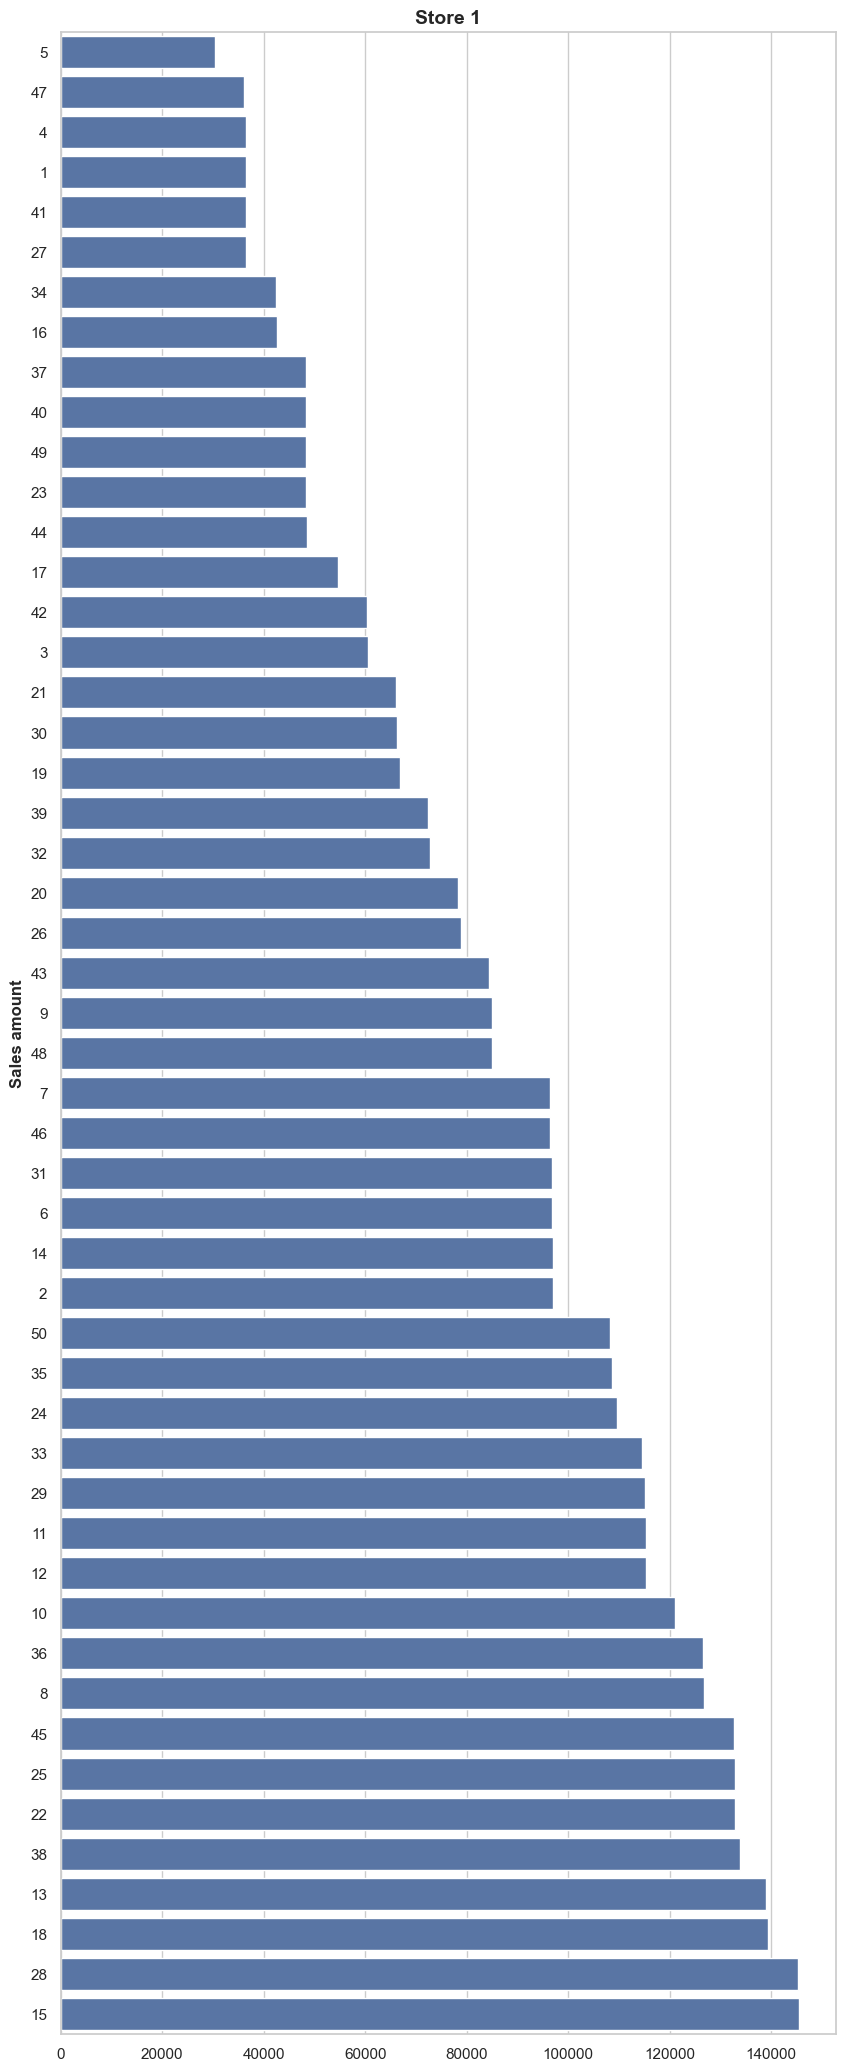

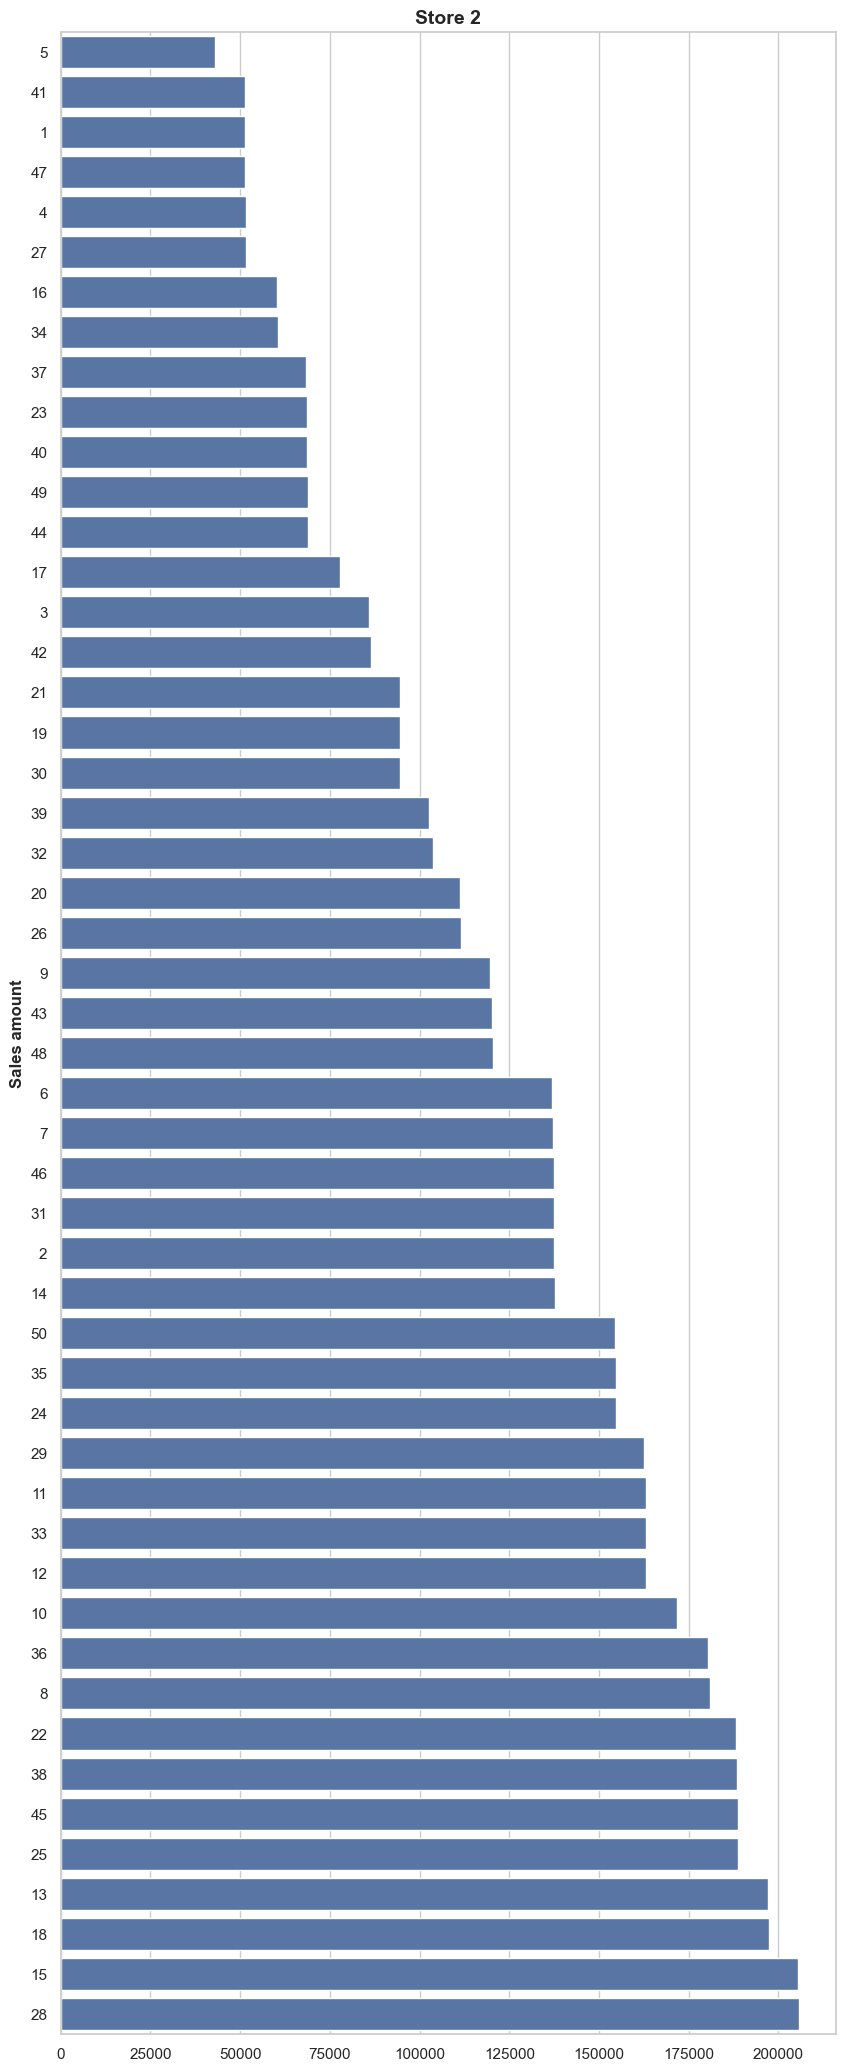

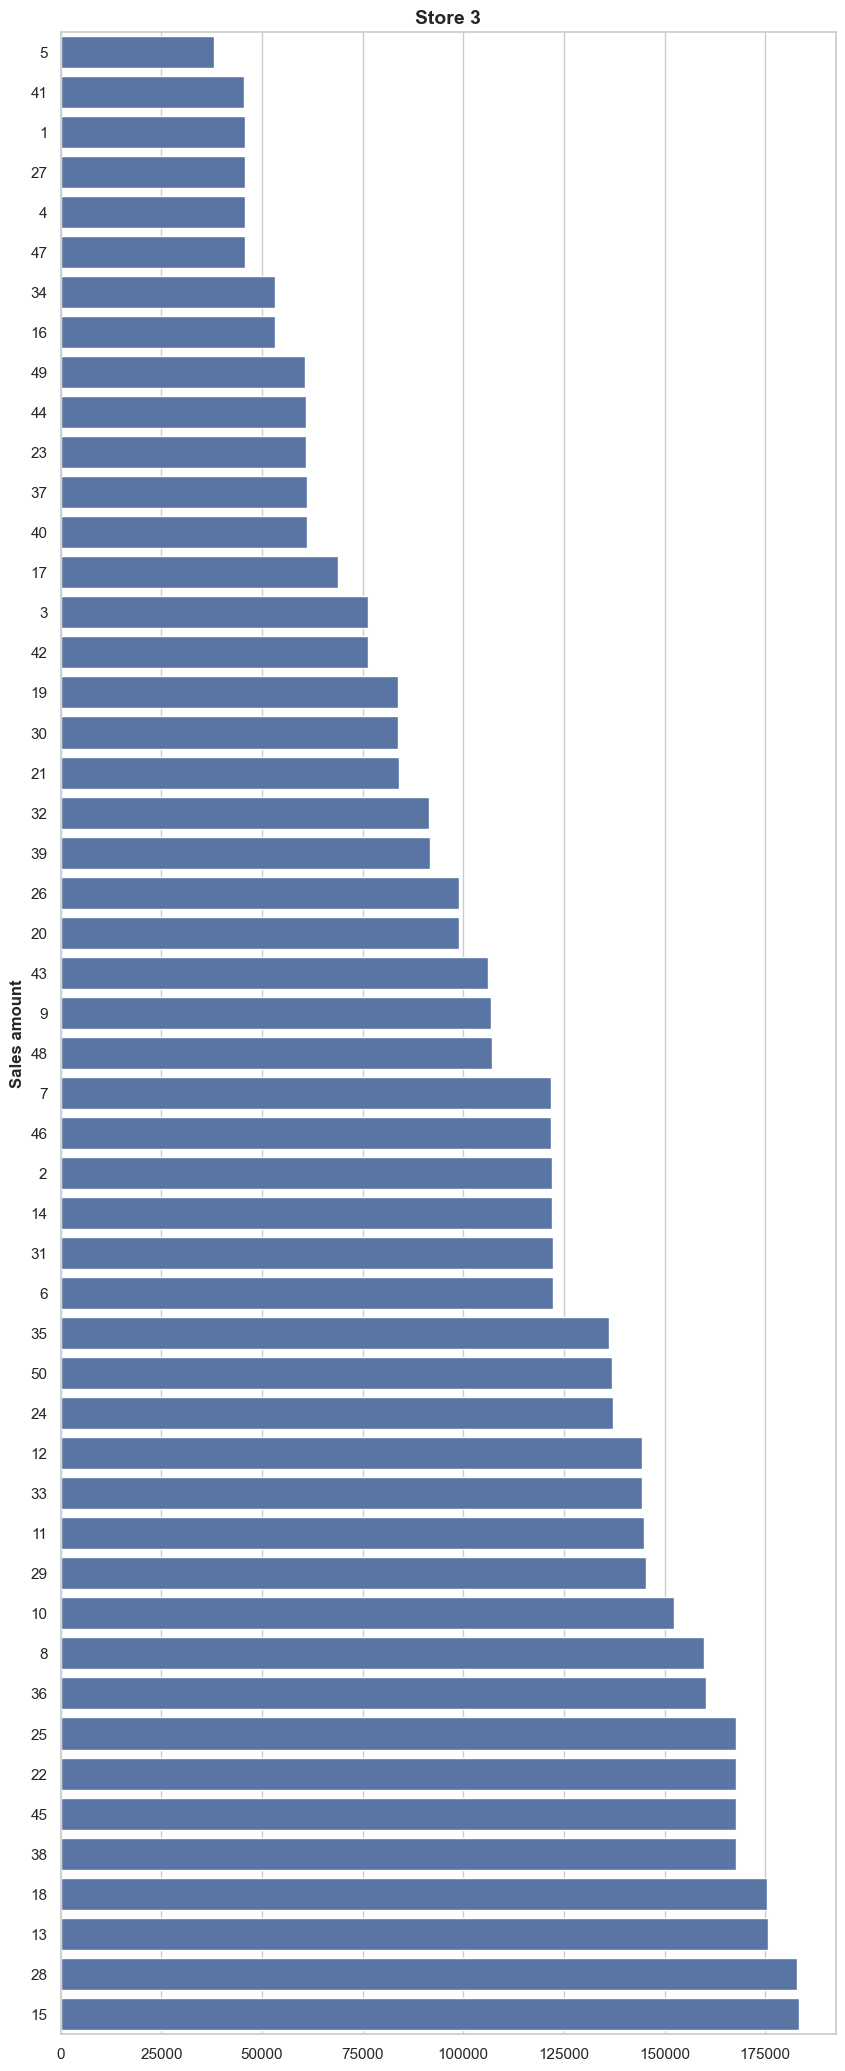

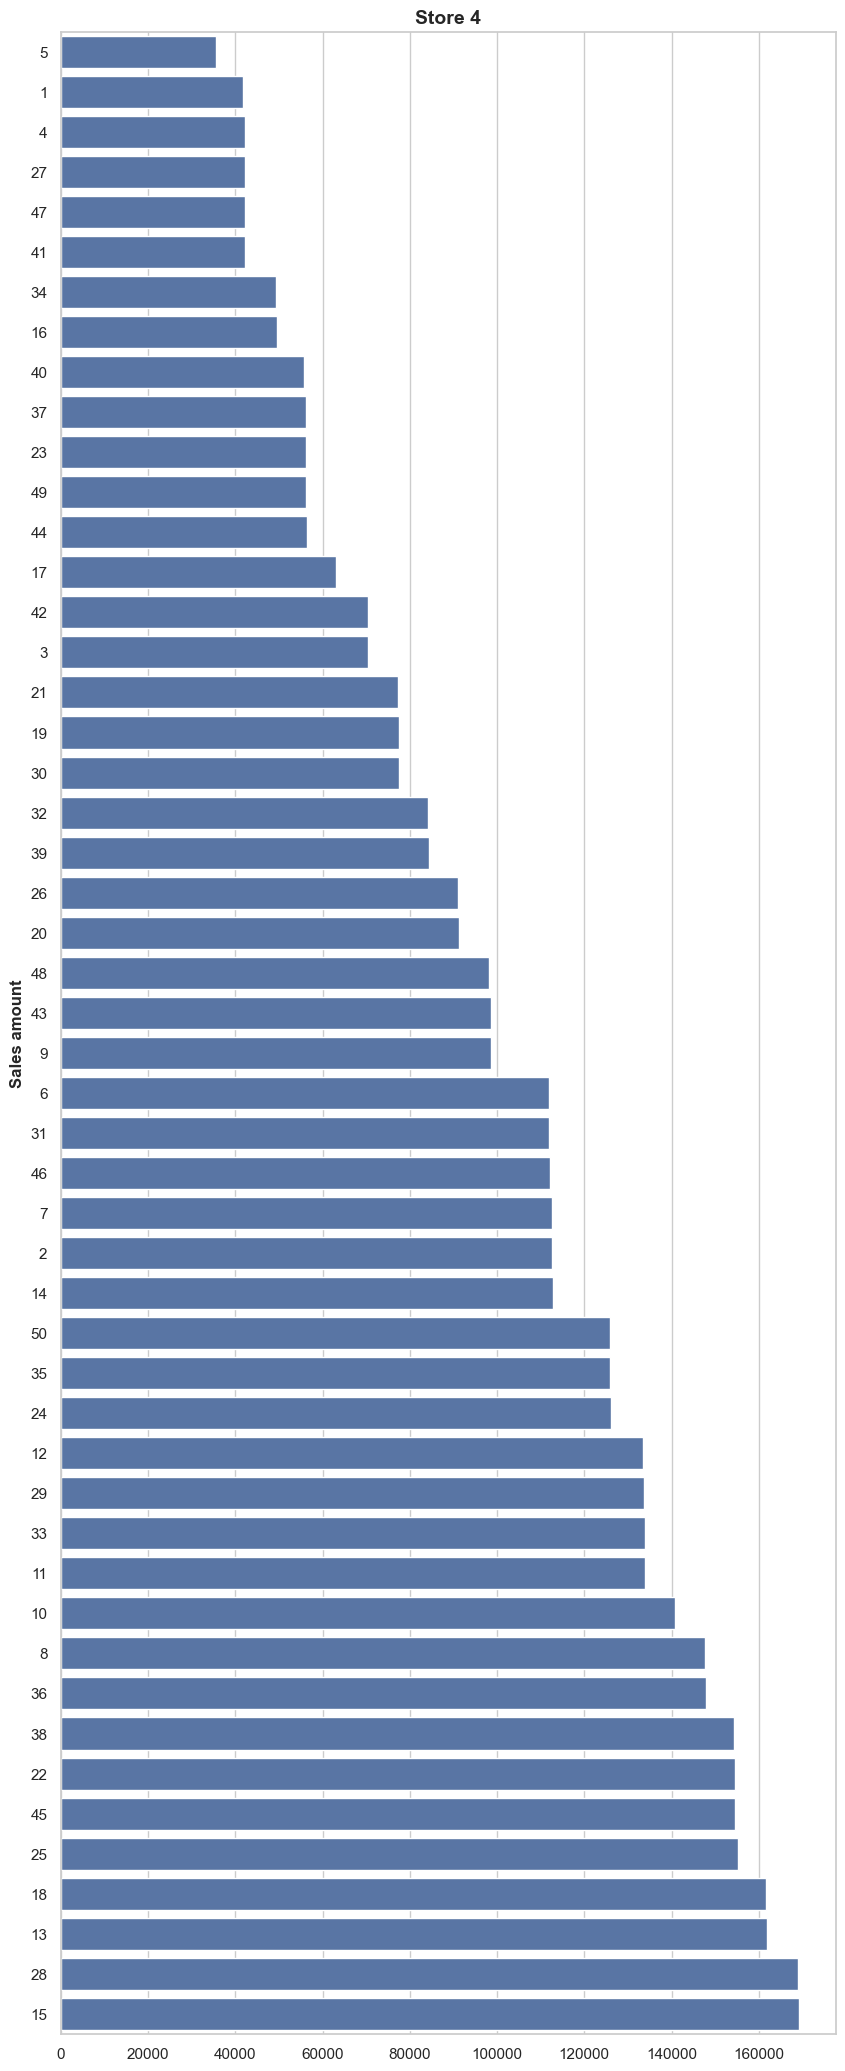

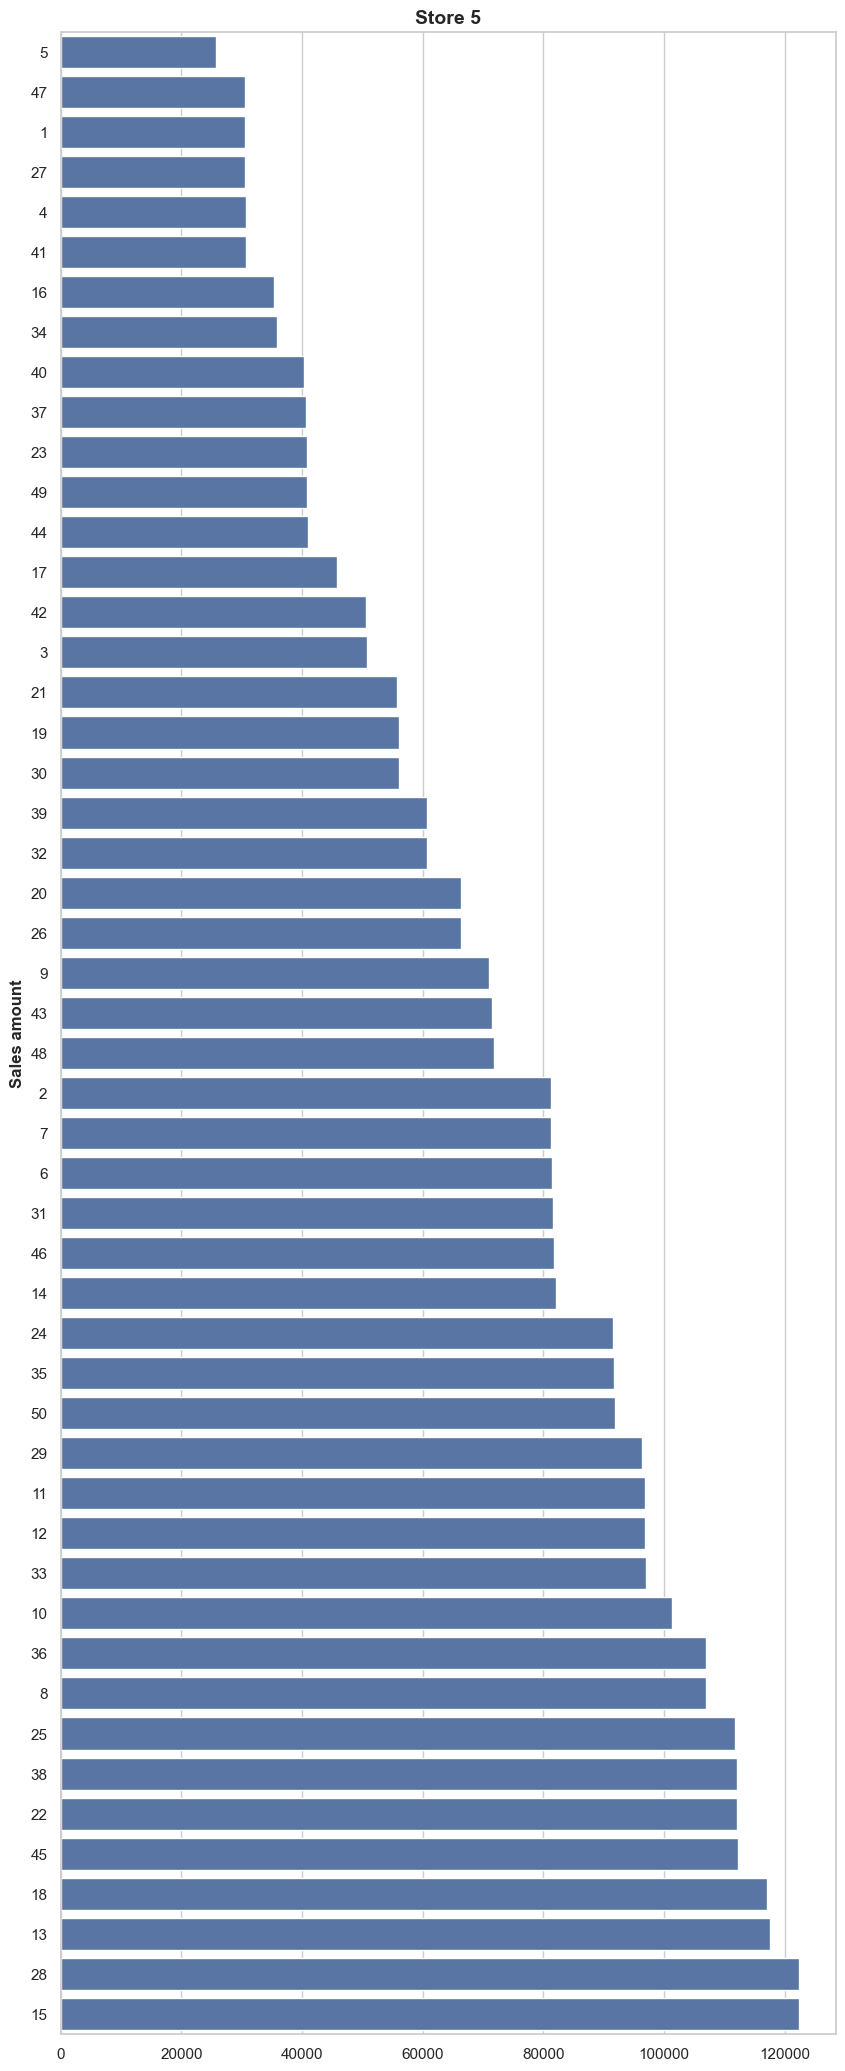

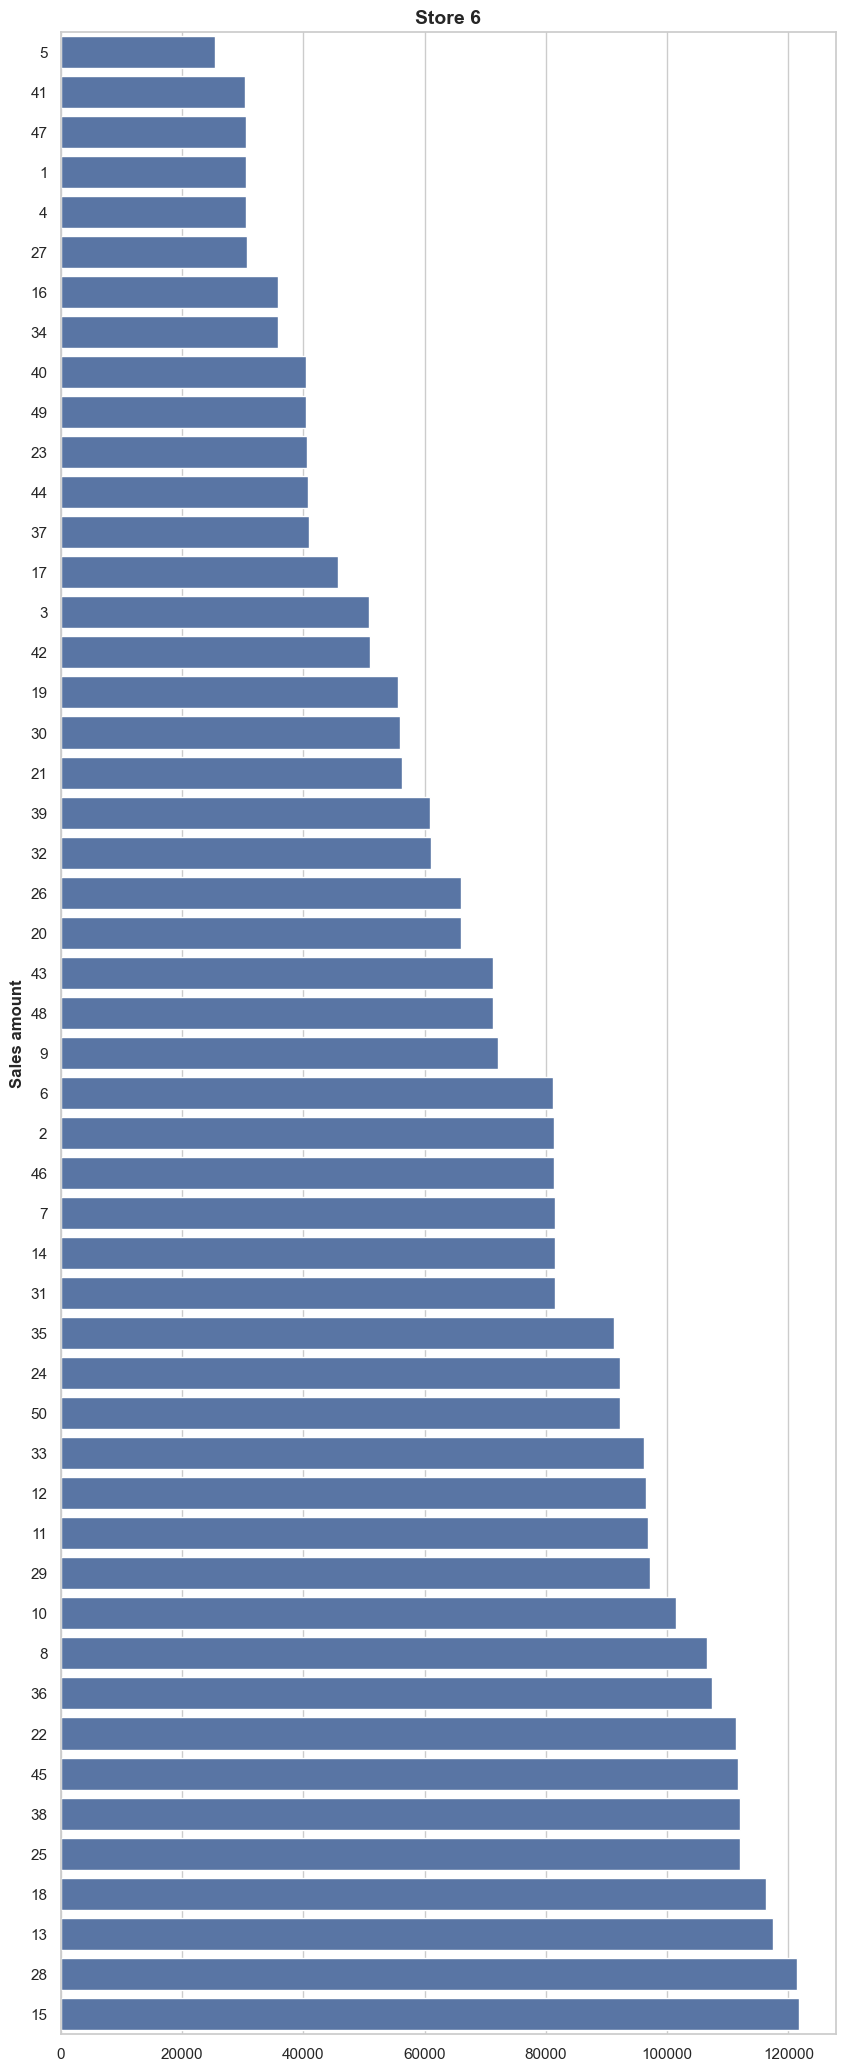

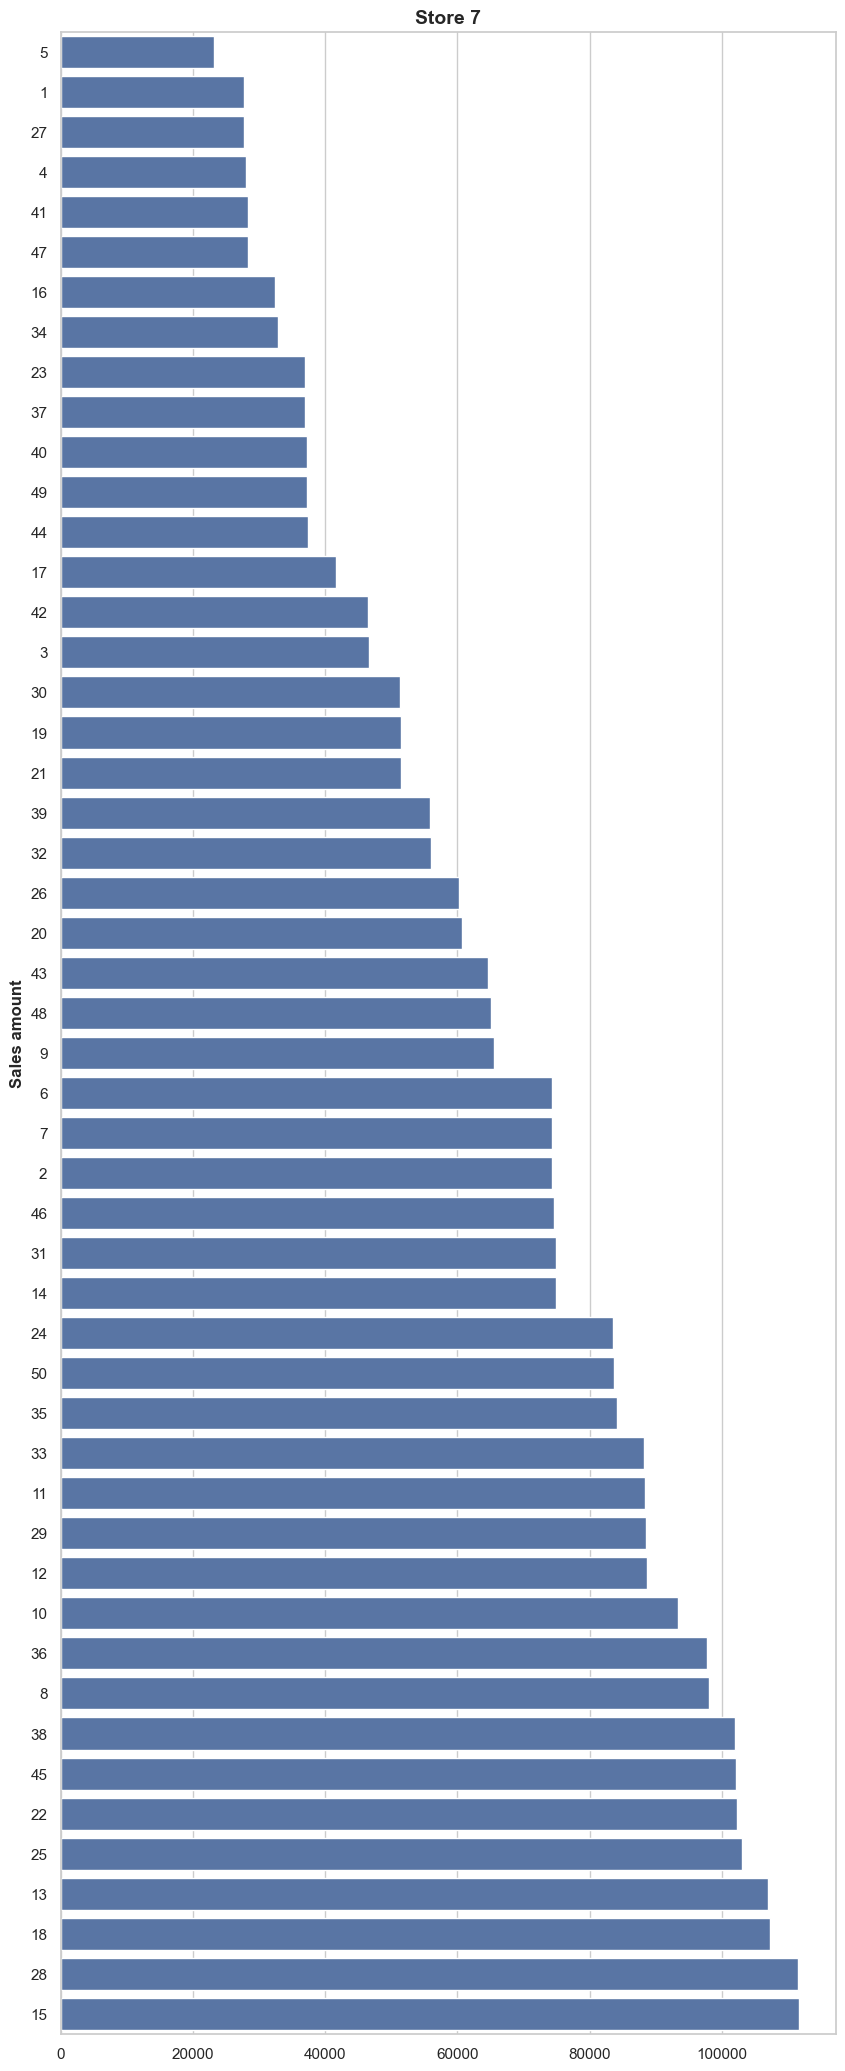

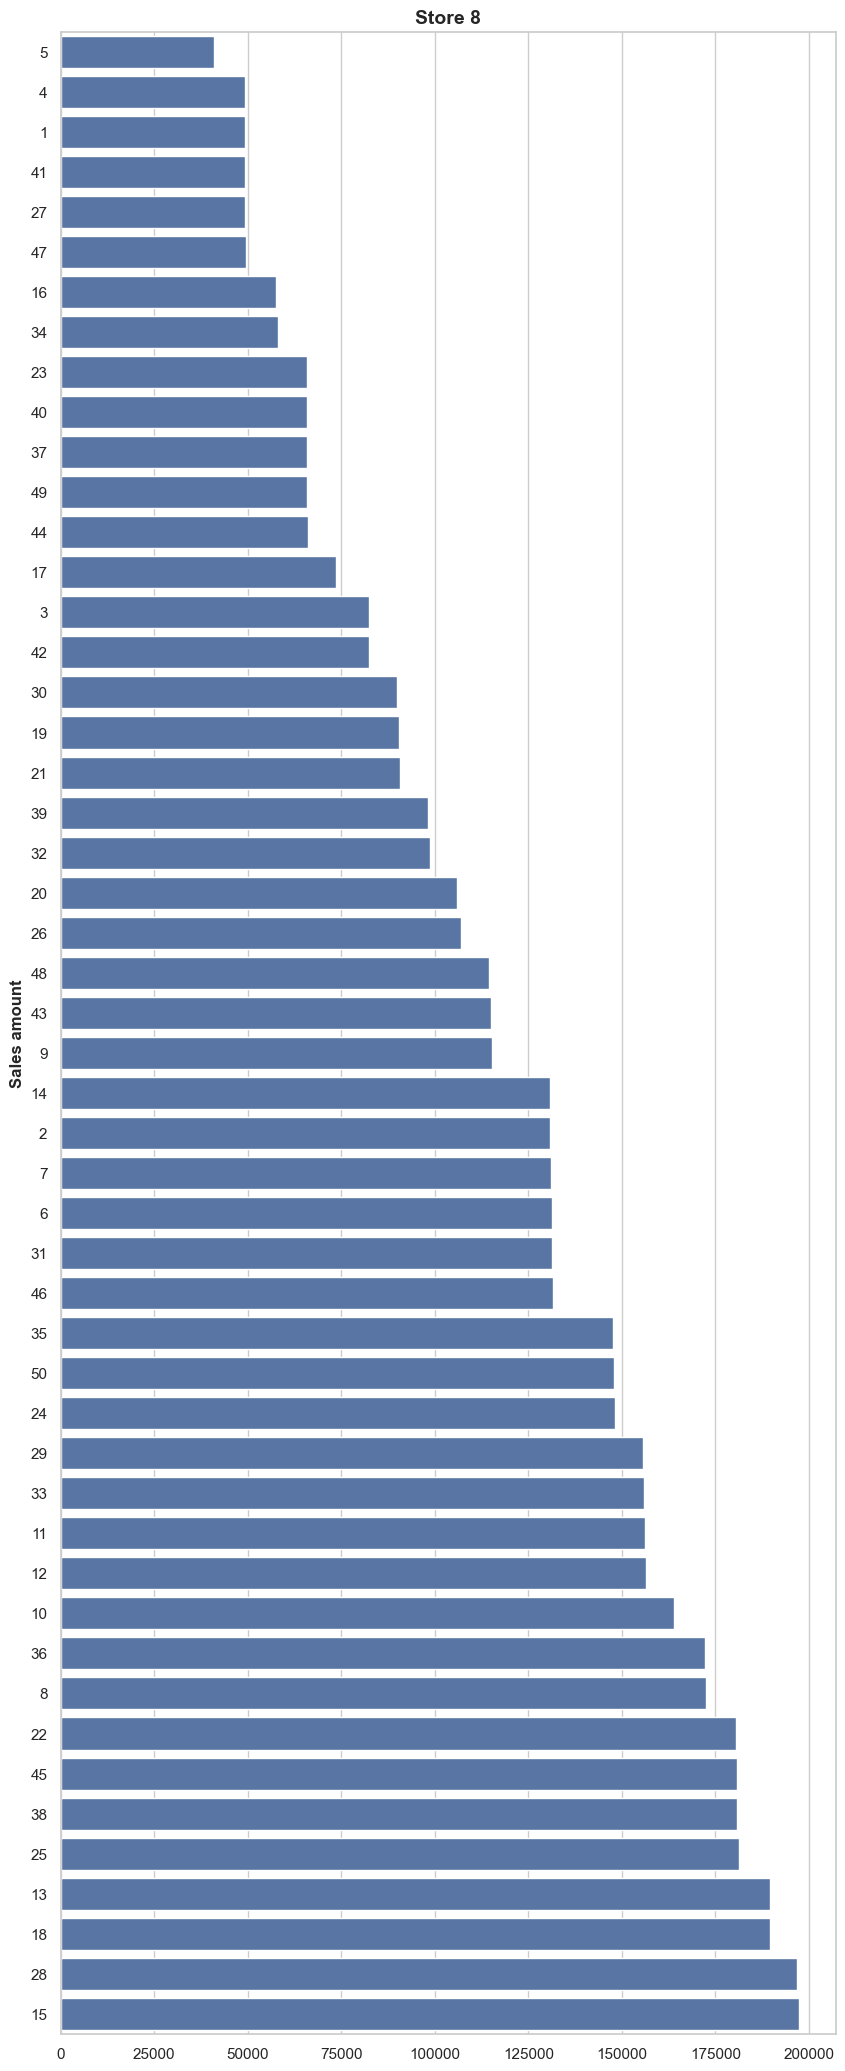

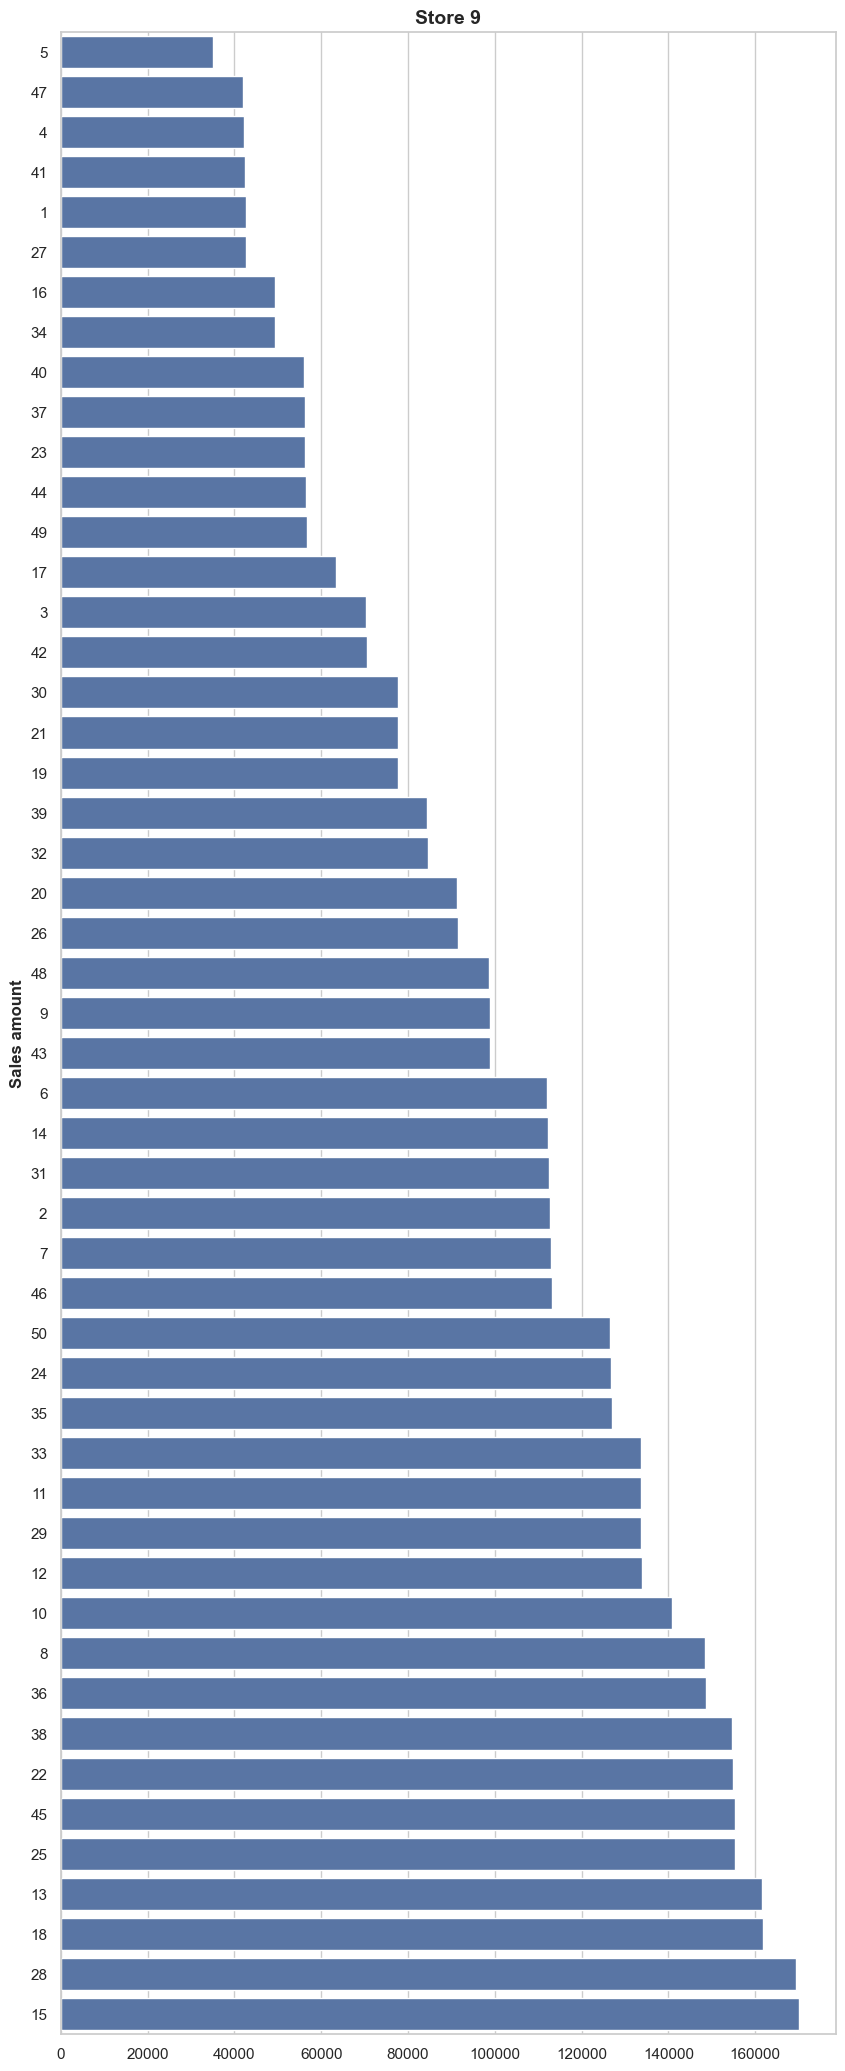

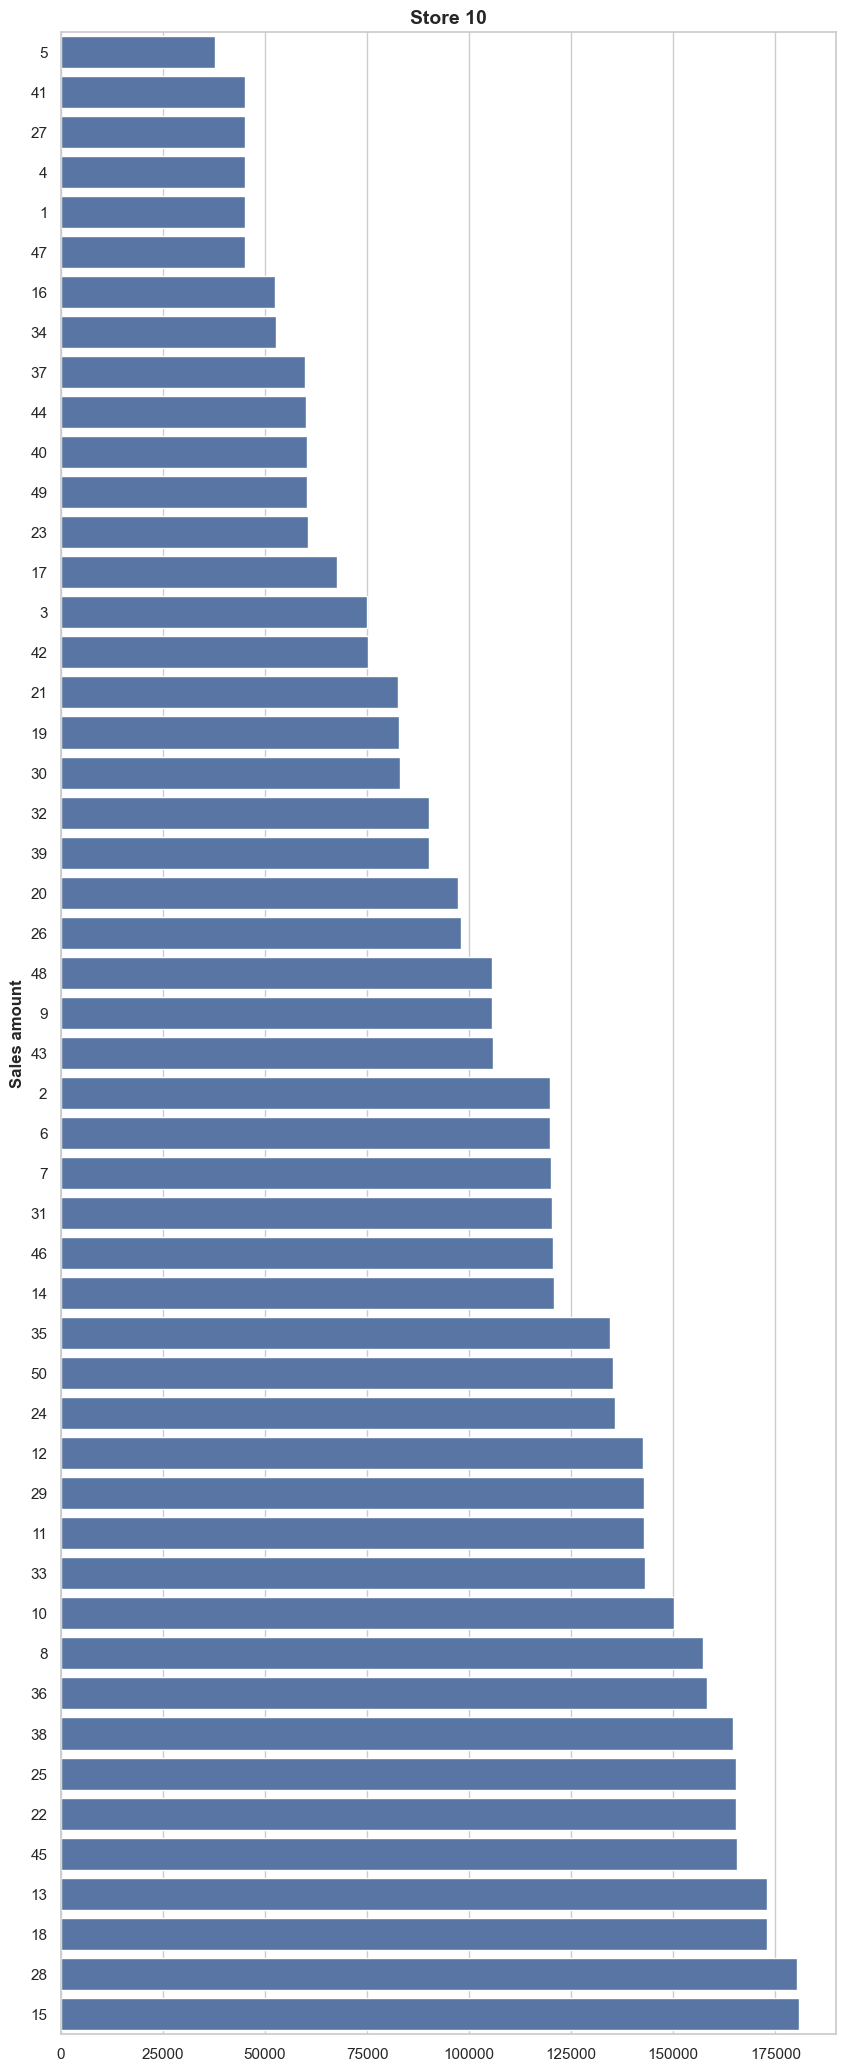

In [8]:
sns.set_theme(style="whitegrid")

for i in range(10):
    
    test_df = train_df[train_df["store"] == i + 1]
    test_df = test_df.reset_index()
    test_df = test_df.groupby("item", as_index=False)["sales"].sum()
    sorted_df = test_df.sort_values(by="sales", ascending=True)
    
    # Ensure the 'item' column is ordered by sales
    sorted_df["item"] = sorted_df["item"].astype("category").cat.reorder_categories(sorted_df["item"], ordered=True)
    
    plt.figure(figsize=(10,26))
    
    sns.barplot(x="sales", y="item", legend=False, data=sorted_df)
    plt.ylabel("Sales amount")
    plt.xlabel("")
    plt.title(f"Store {i + 1}", fontsize=14, weight='bold')
    
    plt.show()

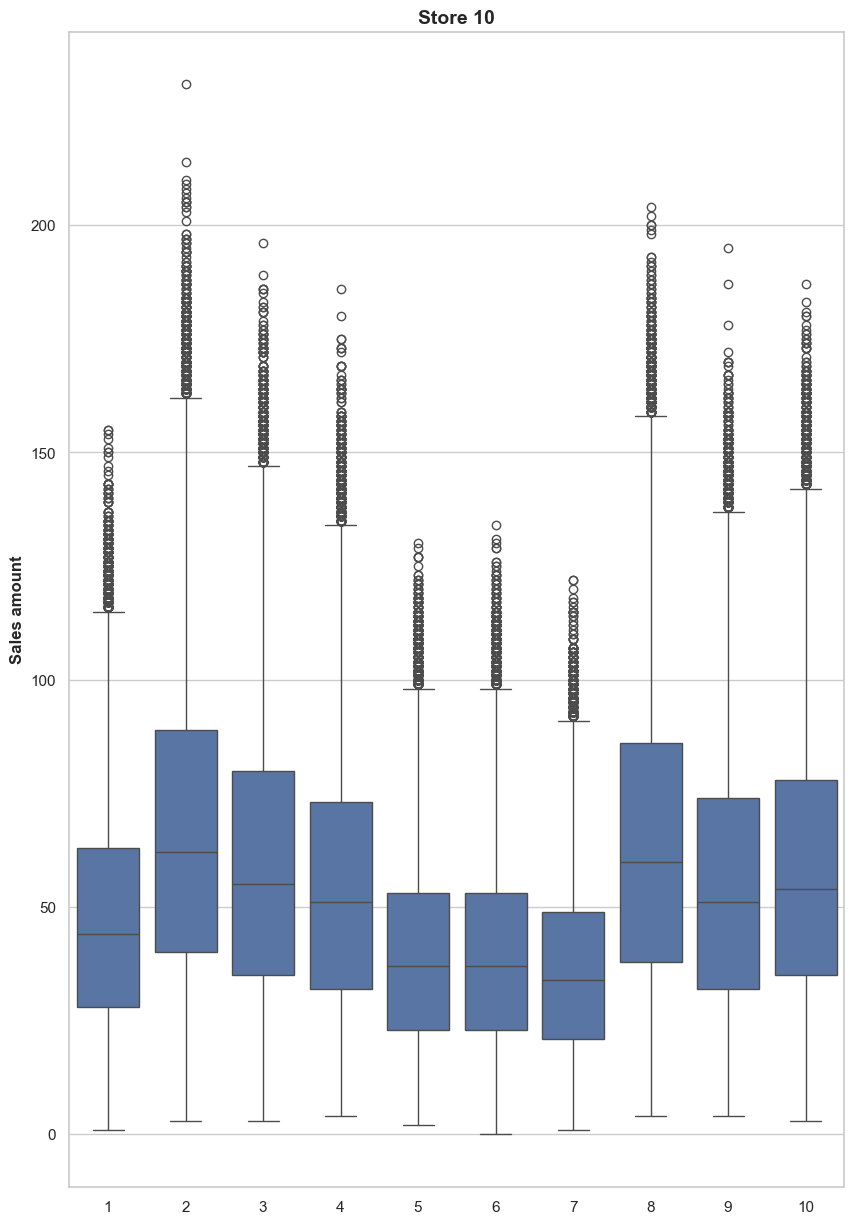

In [9]:
sns.set_theme(style="whitegrid")
    
plt.figure(figsize=(10,15))

sns.boxplot(x="store", y="sales", legend=False, data=train_df)
plt.ylabel("Sales amount")
plt.xlabel("")
plt.title(f"Store {i + 1}", fontsize=14, weight='bold')

plt.show()

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

<Axes: xlabel='date'>

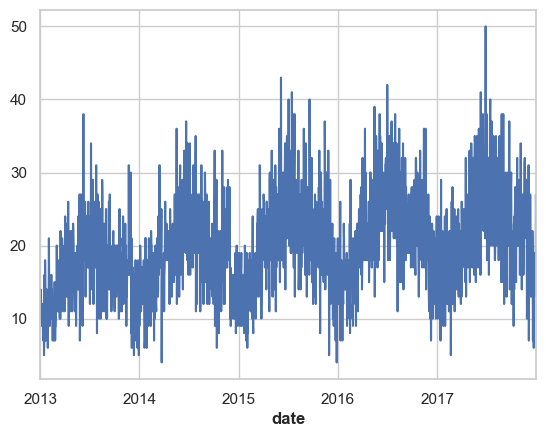

In [10]:
store_one = train_df["store"] == 1
item_one = train_df["item"] == 1

filtered_df = train_df.loc[store_one & item_one]

filtered_df["sales"].plot()

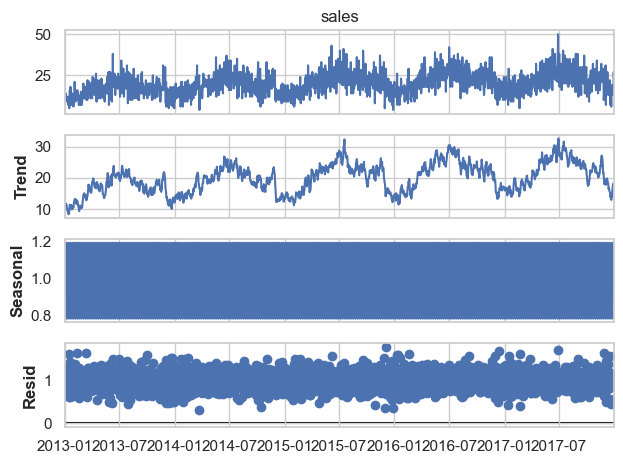

In [11]:
decomposition_plot_multi = seasonal_decompose(filtered_df['sales'],
                                              model='multiplicative')
decomposition_plot_multi.plot()
plt.show()

Maybe for better visualisation we can use shorted period to see how does seasonal part looks and not to be overwhelmed with amount of information. Also in trend we can see some seasonality as well, this can be come kinf of cycle, i beylive this represents a year. 

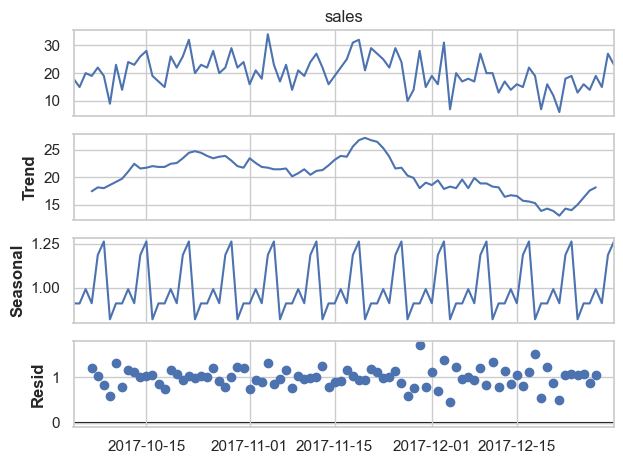

In [12]:
decomposition_plot_multi_short = seasonal_decompose(filtered_df[-90:]['sales'],
                                              model='multiplicative')
decomposition_plot_multi_short.plot()
plt.show()

Here we can see there is seasonal element that seems to be repitting every week or so

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [13]:
series = TimeSeries.from_dataframe(filtered_df, value_cols='sales')

series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)>
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

In [14]:
train,val = series.split_before(pd.Timestamp("2017-10-01"))

val

<TimeSeries (DataArray) (date: 92, component: 1, sample: 1)>
array([[[21.]],

       [[12.]],

       [[18.]],

       [[15.]],

       [[20.]],

       [[19.]],

       [[22.]],

       [[19.]],

       [[ 9.]],

       [[23.]],

...

       [[ 6.]],

       [[18.]],

       [[19.]],

       [[13.]],

       [[16.]],

       [[14.]],

       [[19.]],

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 2017-10-01 2017-10-02 ... 2017-12-31
  * component  (component) object 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

<Figure size 1000x600 with 0 Axes>

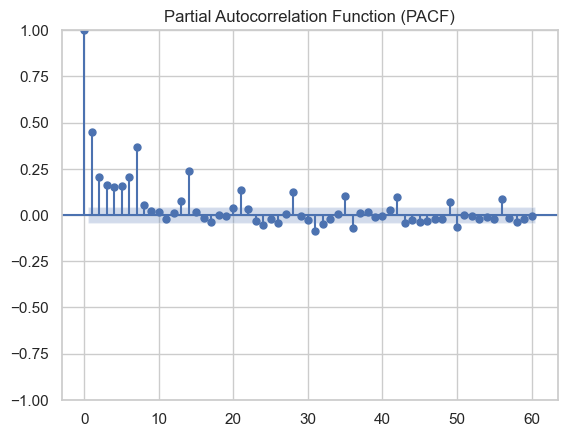

In [15]:
plt.figure(figsize=(10, 6))
plot_pacf(filtered_df["sales"], lags=60, method='ywm', )
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [16]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


We can see that we have weekly seasonality.And also we can see some kind of cycle in trend

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

In [17]:
from darts.models import NaiveDrift, NaiveSeasonal

<Axes: xlabel='date'>

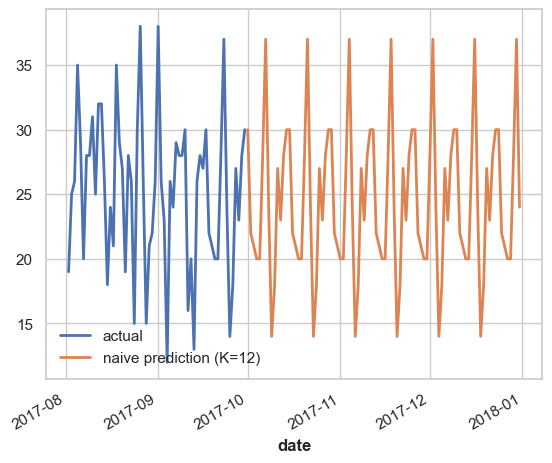

In [18]:
seasonal_model = NaiveSeasonal(K=14)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(val))

train[-60:].plot(label="actual")
seasonal_forecast.plot(label="naive prediction (K=12)")

<Axes: xlabel='date'>

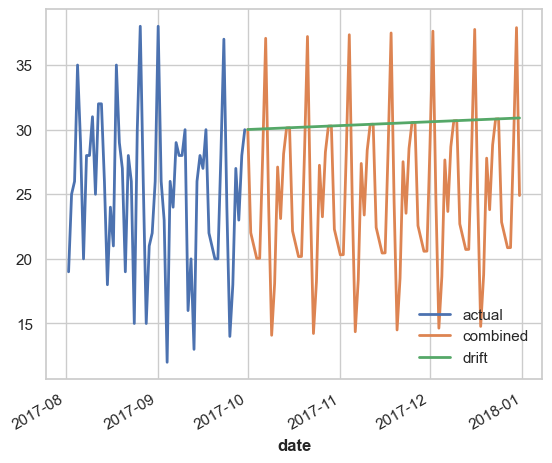

In [19]:

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(val))

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

train[-60:].plot(label="actual")
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [30]:
from darts.metrics import mape

def eval_pred(forecast):
    print(
        f"Mean absolute percentage error for model: {mape(val, forecast):.2f}%."
    )


Mean absolute percentage error for model: 42.18%.


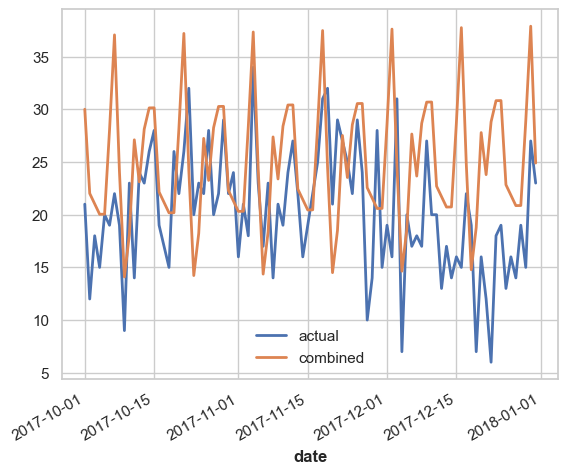

In [31]:
val.plot(label="actual")
combined_forecast.plot(label="combined")

eval_pred(combined_forecast)

To be honest 42% does not look like good prediction, the graph looks not so good as well

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

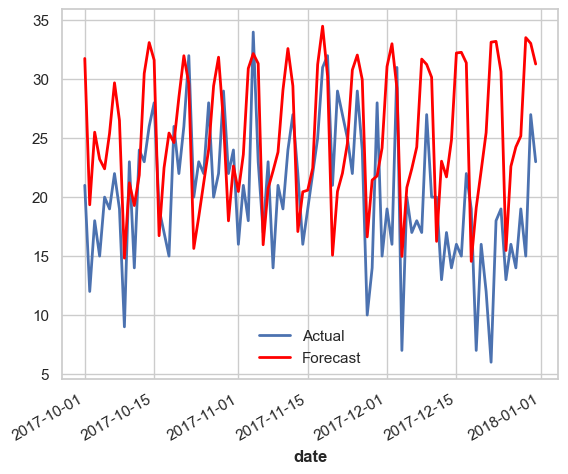

Mean absolute percentage error for model: 42.94%.


In [32]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler
import numpy as np

def enrich_with_date_features(df):
  df["quarter"] = df['date'].dt.quarter
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  return df

# Додавання ознак дати
train_transformed = enrich_with_date_features(train.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(val.pd_dataframe().reset_index())

# Масштабування даних
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
test_transformed = scaler.transform(val)

# Побудова моделі XGBoost
model = XGBModel(
    lags=60,
    output_chunk_length=1,
    n_estimators=400,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)
model.fit(train_transformed)
pred = model.predict(6)
pred.values()

forecast = scaler.inverse_transform(model.predict(len(val)))
val.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()
eval_pred(forecast)

This predictions is closer to reality. 30% seems a bit too much still. But this can be due to data nature (it has big amount of randomness to it)

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

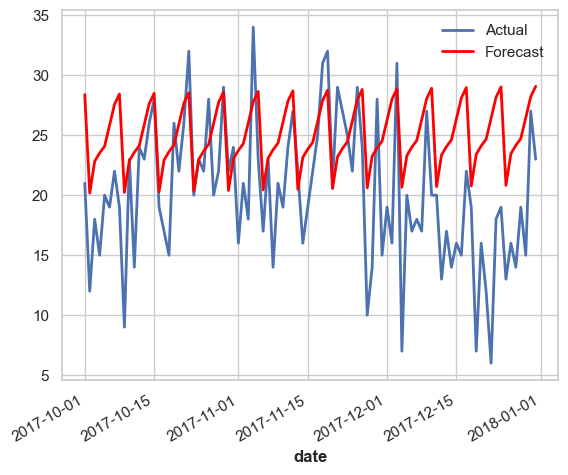

Mean absolute percentage error for model: 38.98%.


In [33]:
def plot_results(series, forecast):
  # Візуалізація результатів
  val.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_pred(forecast)

model = ExponentialSmoothing()
fit_and_plot(model, series, train, val)

This also seems like pretty bad prediction. 

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


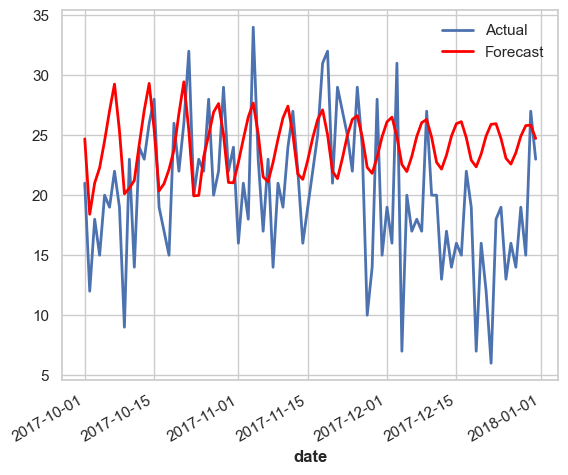

Mean absolute percentage error for model: 37.75%.


In [34]:
from darts.models import ARIMA

# Побудова та тренування моделі ARIMA
model = ARIMA(p=30, d=2, q=1) # try p=12
fit_and_plot(model, series, train, val)

I tried different parameters but this still performs pretty bad.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

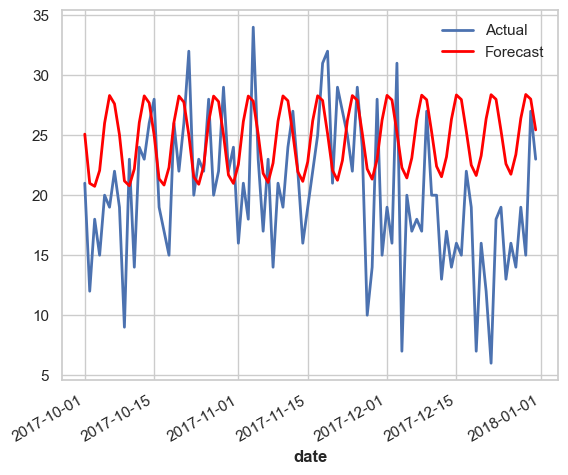

Mean absolute percentage error for model: 40.51%.


In [35]:
model = AutoARIMA()
fit_and_plot(model, series, train, val)

This one is even worse, than the last one.

14. Натренуйте модель Prophet та зробіть висновок про її якість.

21:54:36 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] done processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] done processing


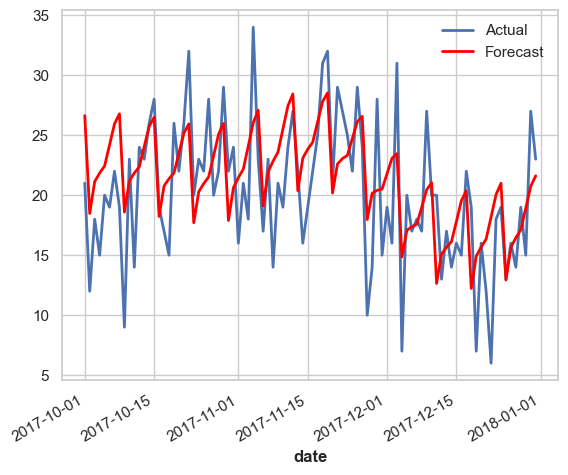

Mean absolute percentage error for model: 23.80%.


In [36]:
from darts.models import Prophet

model = Prophet()
model.fit(train)

forecast = model.predict(len(val))

fit_and_plot(model, series, train, val)

This model has the best forecast yet, we can clearly see how it found trend inside of the data.

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)>
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.8 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.007     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

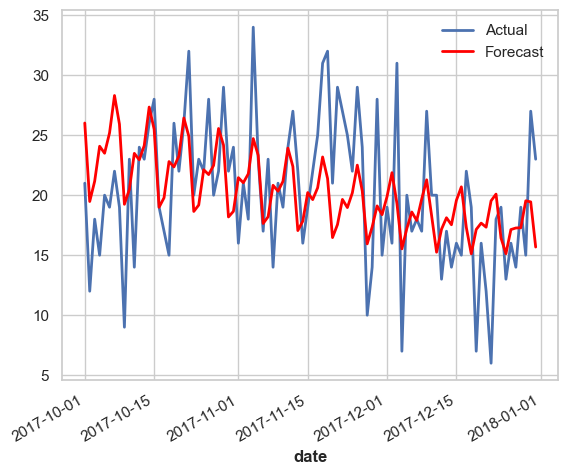

TypeError: eval_pred() takes 1 positional argument but 3 were given

In [52]:
from darts.models import RNNModel

from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Масштабування даних
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

display(series)

# Побудова та тренування моделі LSTM
model = RNNModel(
    model="LSTM",
    input_chunk_length=14,
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    force_reset=True,
)
model.fit(
    train_transformed,
    val_series=val_transformed,
    verbose=True)

# Прогнозування
forecast = scaler.inverse_transform(model.predict(len(val)))

# Візуалізація результатів
val.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [53]:
eval_pred(forecast)

Mean absolute percentage error for model: 26.16%.


tried different artguments its always this wierd prediction

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

22:14:37 - cmdstanpy - INFO - Chain [1] start processing
22:14:37 - cmdstanpy - INFO - Chain [1] done processing
22:14:37 - cmdstanpy - INFO - Chain [1] start processing
22:14:37 - cmdstanpy - INFO - Chain [1] done processing


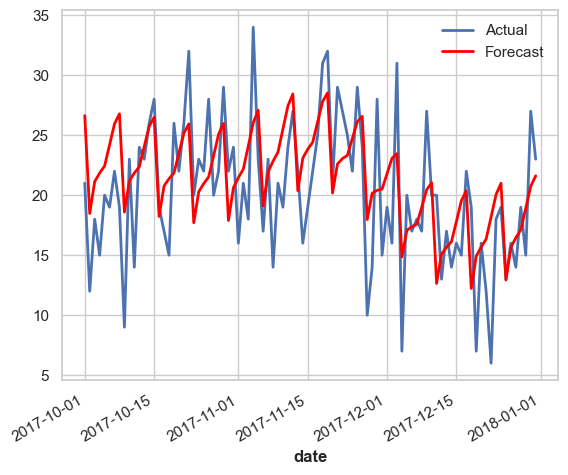

Mean absolute percentage error for model: 23.80%.


  0%|          | 0/363 [00:00<?, ?it/s]

22:14:37 - cmdstanpy - INFO - Chain [1] start processing
22:14:37 - cmdstanpy - INFO - Chain [1] done processing
22:14:38 - cmdstanpy - INFO - Chain [1] start processing
22:14:38 - cmdstanpy - INFO - Chain [1] done processing
22:14:38 - cmdstanpy - INFO - Chain [1] start processing
22:14:38 - cmdstanpy - INFO - Chain [1] done processing
22:14:38 - cmdstanpy - INFO - Chain [1] start processing
22:14:38 - cmdstanpy - INFO - Chain [1] done processing
22:14:38 - cmdstanpy - INFO - Chain [1] start processing
22:14:38 - cmdstanpy - INFO - Chain [1] done processing
22:14:38 - cmdstanpy - INFO - Chain [1] start processing
22:14:38 - cmdstanpy - INFO - Chain [1] done processing
22:14:39 - cmdstanpy - INFO - Chain [1] start processing
22:14:39 - cmdstanpy - INFO - Chain [1] done processing
22:14:39 - cmdstanpy - INFO - Chain [1] start processing
22:14:39 - cmdstanpy - INFO - Chain [1] done processing
22:14:39 - cmdstanpy - INFO - Chain [1] start processing
22:14:39 - cmdstanpy - INFO - Chain [1]

MAPE = 20.99%


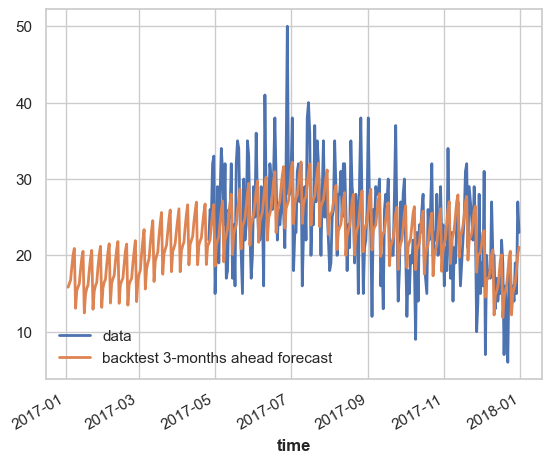

In [57]:
from darts.models import Prophet

model = Prophet()
model.fit(train)

forecast = model.predict(len(val))

fit_and_plot(model, series, train, val)

hfc_params = {
    "series": series,
    "start": pd.Timestamp("2017-10-01"),  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 3,
    "verbose": True,
}

historical_fcast = model.historical_forecasts(last_points_only=True, **hfc_params)

series[-250:].plot(label="data")
historical_fcast.plot(label="backtest 3-months ahead forecast")
print(f"MAPE = {mape(series, historical_fcast):.2f}%")

  0%|          | 0/30 [00:00<?, ?it/s]

22:16:33 - cmdstanpy - INFO - Chain [1] start processing
22:16:34 - cmdstanpy - INFO - Chain [1] done processing
22:16:34 - cmdstanpy - INFO - Chain [1] start processing
22:16:34 - cmdstanpy - INFO - Chain [1] done processing
22:16:34 - cmdstanpy - INFO - Chain [1] start processing
22:16:34 - cmdstanpy - INFO - Chain [1] done processing
22:16:34 - cmdstanpy - INFO - Chain [1] start processing
22:16:34 - cmdstanpy - INFO - Chain [1] done processing
22:16:34 - cmdstanpy - INFO - Chain [1] start processing
22:16:34 - cmdstanpy - INFO - Chain [1] done processing
22:16:35 - cmdstanpy - INFO - Chain [1] start processing
22:16:35 - cmdstanpy - INFO - Chain [1] done processing
22:16:35 - cmdstanpy - INFO - Chain [1] start processing
22:16:35 - cmdstanpy - INFO - Chain [1] done processing
22:16:35 - cmdstanpy - INFO - Chain [1] start processing
22:16:35 - cmdstanpy - INFO - Chain [1] done processing
22:16:35 - cmdstanpy - INFO - Chain [1] start processing
22:16:35 - cmdstanpy - INFO - Chain [1]

MAPE = 23.54%


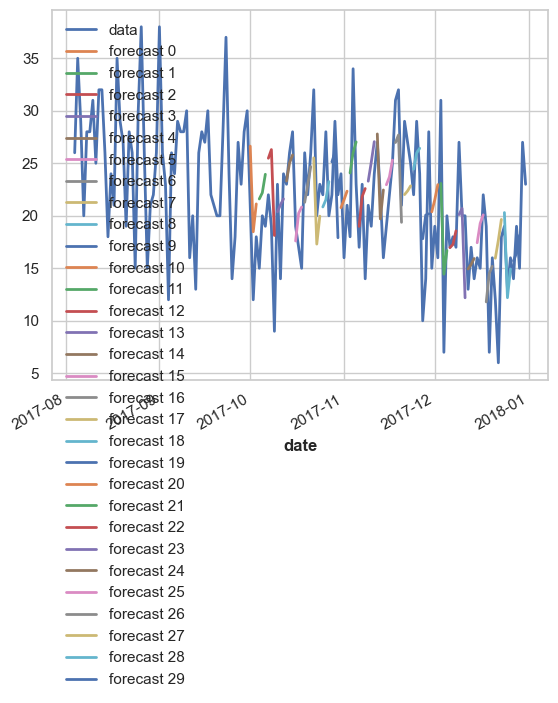

In [59]:
hfc_params = {
    "series": series,
    "start": pd.Timestamp("2017-10-01"),  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 3,
    "verbose": True,
}

historical_fcast_all = model.historical_forecasts(last_points_only=False, stride=3, **hfc_params)

series[-150:].plot(label="data")
for idx, hfc in enumerate(historical_fcast_all):
    hfc.plot(label=f"forecast {idx}")

from darts import concatenate
historical_fcast_all = concatenate(historical_fcast_all, axis=0)
print(f"MAPE = {mape(series, historical_fcast_all):.2f}%")

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

I would say i would try 2 different ways: 
- separate Prophet model for each store and for each different item, this would result in many relatevly simple models but each of them would do relatevly good forecast
- one model that would use all the given information, this could be xgboost or lgbm, i would try different variants, maybe some of those woul find realtion beween classes of items and stores and make good estimation

I think that one of those approaches would give good results, as extra idea i would try some RNN architecture.